# Skin Cancer PCA

## Install MONAI

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
pip install fastai==2.7.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 324.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have 

In [3]:
import fastai
fastai.__version__

'2.7.1'

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

## Read image filenames from the dataset folders

Ok, so we have a "training" directory, called train_dir:

In [5]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [16]:
#train
class_names0 = os.listdir(train_dir)
print(class_names0)
print('\n')
input('these are the directories in `train_dir` : and also the classes\n')
class_names = sorted(class_names0)
print(class_names)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

['pigmented benign keratosis', 'melanoma', 'vascular lesion', 'actinic keratosis', 'squamous cell carcinoma', 'basal cell carcinoma', 'seborrheic keratosis', 'dermatofibroma', 'nevus']




these are the directories in `train_dir` : and also the classes
 


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [17]:
num_total

2239

Ok, let's load this into a fastai style dataloader. This might take several days, but it is doable. Also great practise on FastAI basics anyway. 

In [7]:
#FastAI import here as needed
from fastai.vision.all import *

In [9]:
path=get_image_files(train_dir)#, recurse=True, folders=None)
class_names = [i.as_posix() for i in path]

import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None
    
class_names = [extract_text(i) for i in class_names]

In [50]:
#This cell is "working" so leave here for now
fnames = get_image_files(train_dir)

def label_func(x): return extract_text(x.as_posix())



dls = ImageDataLoaders.from_path_func(train_dir, fnames, label_func,
                                      bs=2000,
                                      item_tfms=Resize(32),
                                      valid_pct=0,
                                    )

train_dls = dls.train
x,y = dls.one_batch()

In [81]:
#Debugging cell
_fnames = fnames[0:20]
_fnames = fnames



dls = ImageDataLoaders.from_path_func(train_dir, _fnames, label_func,
                                      bs=len(_fnames),
                                      item_tfms=Resize(32),
                                      valid_pct=0,
                                    )

train_dls = dls.train
x,y = dls.one_batch()

In [83]:
print(len(_fnames))
x.shape

2239


torch.Size([2239, 3, 32, 32])

In [21]:
#Compute the mean and standard deviation of the dataset: 
def compute_mean_std(dls):
    # Initialize variables to store the sum and sum of squares of the data
    channel_sum = [0, 0, 0]
    channel_sum_squares = [0, 0, 0]

    # Iterate over the data in the dataloader
    for data,y in dls:
        
        batch_size, _, height, width = data.shape

        # Compute the sum and sum of squares of the data for each channel
        for channel in range(3):
            channel_sum[channel] += data[:, channel, :, :].sum()
            channel_sum_squares[channel] += (data[:, channel, :, :] ** 2).sum()

    # Calculate the number of elements in the data
    num_elements = batch_size * height * width * len(dls)

    # Calculate the mean and standard deviation for each channel
    means = [channel_sum[i] / num_elements for i in range(3)]
    stddevs = [((channel_sum_squares[i] / num_elements) - means[i]**2)**0.5 for i in range(3)]

    return means, stddevs

# Example usage
means, stddevs = compute_mean_std(train_dls)
print("Means:", means)
print("Standard deviations:", stddevs)

Normalize.from_stats(mean=means,std=stddevs)

Means: [TensorImage(0.7484), TensorImage(0.5845), TensorImage(0.5839)]
Standard deviations: [TensorImage(0.1278), TensorImage(0.1446), TensorImage(0.1627)]


Normalize -- {'mean': tensor([[[[0.7484]],

         [[0.5845]],

         [[0.5839]]]]), 'std': tensor([[[[0.1278]],

         [[0.1446]],

         [[0.1627]]]]), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
(Tabular,object) -> encodes
decodes: (TensorImage,object) -> decodes
(Tabular,object) -> decodes

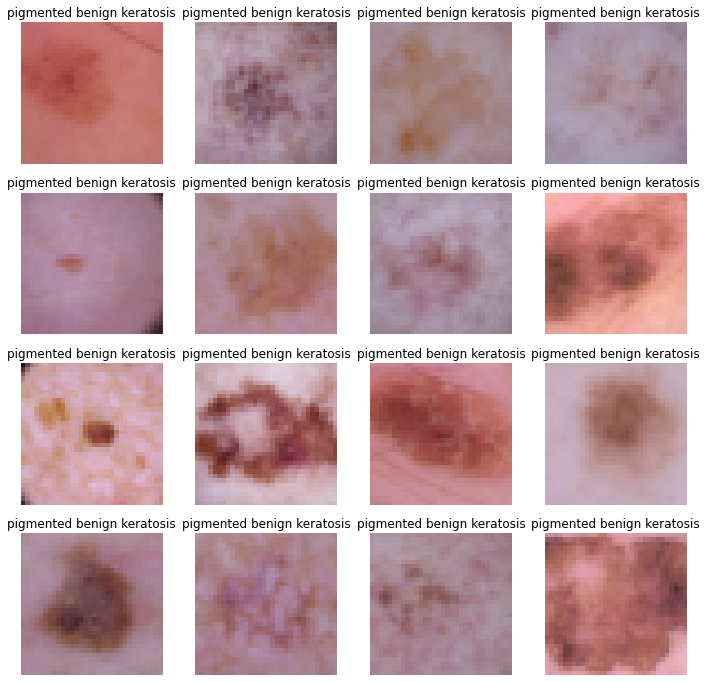

In [80]:
dls.show_batch(max_n=16)

Ok, let's apply PCA to this dataset:

In [127]:
dls = ImageDataLoaders.from_path_func(train_dir, fnames, label_func,
                                      bs=len(fnames),
                                      item_tfms=Resize(32),
                                      valid_pct=0,
                                    )

train_dls = dls.train
x,y = dls.one_batch() #this will be entire training set

test_eq(x.shape[0],num_total)

In [126]:
dls.vocab

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [85]:
#Resize for PCA
x = x.view(x.shape[0],-1)
x.shape

torch.Size([2239, 3072])

In [86]:
# Convert the tensor to a NumPy array for PCA
x_np = x.numpy()
y_np = y.numpy()
y_np = y_np.reshape(y_np.shape[0],1) #reshape target for PCA


Ok! Now we have the training set as numpy array, so we can do PCA.

In [87]:
from sklearn.decomposition import PCA

First we use 2 principal components, and plot the results:

In [88]:
pca = PCA(n_components=2)

In [89]:
pca.fit(x_np)

PCA(n_components=2)

In [90]:
pca.n_components_

2

In [91]:
x_np_pca = pca.transform(x_np)

Ok, PCA is done. Now let's display it:

In [92]:
#put two principal components plus labels into dataframe
_data = np.hstack((x_np_pca,y_np))
principalDf = pd.DataFrame(data = _data
             , columns = ['principal component 1', 'principal component 2','class'])

In [93]:
principalDf

,principal component 1,principal component 2,class
0,0.513976,-1.217556,0.0
1,2.887834,8.151645,4.0
2,-2.340624,-0.442970,5.0
3,-0.243589,4.096193,3.0
4,4.865604,-0.642230,3.0
...,...,...,...
2234,-3.644288,0.695806,1.0
2235,6.715101,-3.987438,3.0
2236,-1.934345,4.031291,5.0
2237,-1.092649,0.459679,2.0


Ok, now let's plot PCA

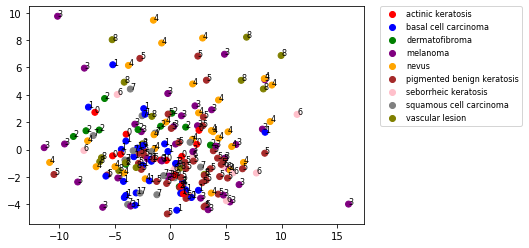

In [94]:
import matplotlib.pyplot as plt

n_samples = 200 #number of samples we want to plot

# Assume that the dataframe is called "principalDf" and the x-axis is "principal component 1"
# and the y-axis is "principal component 2"
x = principalDf['principal component 1'][:n_samples]
y = principalDf['principal component 2'][:n_samples]

# Create a list of colors for each of the 10 categories
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive']

# Convert the values in the 'class' column to integers
principalDf['class'] = principalDf['class'].astype(int)

# Create a scatter plot with different colors for each category
scatter = plt.scatter(x, y, c=[colors[c] for c in principalDf['class'][:n_samples]])

# Add small digits to the plot
for i, txt in enumerate(principalDf['class'][:n_samples]):
    plt.text(x[i], y[i], str(txt), fontsize=8)

# Create a list of handles and labels for the legend
handles = [plt.Line2D((0,1),(0,0), color=color, marker='o', linestyle='') for color in colors]
labels = ['{}'.format(c) for c in sorted(principalDf['class'].unique())]


labels = [dls.vocab[i] for i in range(len(dls.vocab))] #pretty sure this is ok...
# Add a legend and show the plot
#plt.legend(handles, labels)

# Add a legend with a smaller font size and specify the bounding box coordinates
plt.legend(handles, labels, fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


plt.show()


In [95]:
#Check that labels make sense...
test_eq(dls.vocab.o2i['actinic keratosis'],0)
test_eq(dls.vocab.o2i['basal cell carcinoma'],1)

Unsuprisingly, the amount of variance explained (with two principal components) is (relatively) small:

In [96]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[0.35074335 0.14037405]


0.49111742

Let's try again with 30 principal components:

In [97]:
pca = PCA(n_components=30)
pca.fit(x_np)
x_np_pca_95 = pca.transform(x_np)

In [98]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

[0.35074314 0.14037421 0.08126223 0.06546292 0.03675361 0.03091335
 0.02886377 0.02506307 0.02040253 0.01816481 0.01257212 0.01229829
 0.00975239 0.00786407 0.00711042 0.00669935 0.00636851 0.00619909
 0.00543809 0.00510035 0.00462222 0.00388334 0.00358614 0.00349113
 0.00317324 0.00296166 0.00280204 0.00258616 0.00250683 0.00235623]


0.9093753

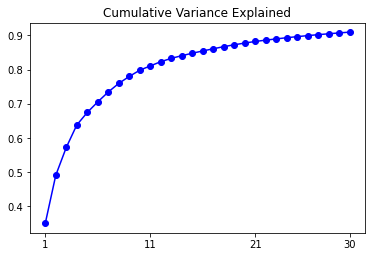

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Assume that the explained variance ratio is stored in a NumPy array called "explained_variance_ratio"
explained_variance_ratio = pca.explained_variance_ratio_

# Get the number of components
n_components = len(explained_variance_ratio)

# Compute the cumulative sum of the explained variance ratio
cumulative_variance_explained = np.cumsum(explained_variance_ratio)

# Create a figure and a subplot
fig, ax = plt.subplots()

# Create a plot of the cumulative variance explained
ax.plot(range(n_components), cumulative_variance_explained, 'bo-')

# Add labels to the x-axis
ax.set_xticks([0, n_components//3, 2*n_components//3, n_components-1])
ax.set_xticklabels([1, n_components//3+1, 2*n_components//3+1, n_components])

# Add a title
ax.set_title("Cumulative Variance Explained")

# Adjust the spacing between the ticks
plt.subplots_adjust(bottom=0.15)

# Show the plot
plt.show()


Ok, great we have run PCA. Perhaps now let's try establishing some baselines (we don't look at the test set yet, but that will be coming quite soon).

Baselines

1) Linear classifier on the raw pixels
2) Linear classifier trained on 30 (?) principal components

3) Repeat 1 and 2 for a resnet instead of a linear classifier.

Question: For our project, how many labels do we want to use? Not many! Also, how many unlabelled samples do we want to use? Also, not many. 

In [104]:
fnames

(#2239) [Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0028100.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0027960.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0025454.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0025876.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0025575.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0028607.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0028347.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0027559.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/ISIC_0027982.jpg'),Path('../input/skin-cancer-isic/skin_cancer_ISIC/Train/pigmented benign keratosis/

In [16]:
valid_frac = 0.2
trainX,trainY = [],[]
valX,valY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX))

1771 468


In [17]:
#test
t_class_names0 = os.listdir(test_dir)
t_class_names = sorted(t_class_names0)
print(t_class_names)
t_num_class = len(t_class_names)
t_image_files = [[os.path.join(test_dir, t_class_name, x) 
               for x in os.listdir(os.path.join(test_dir, t_class_name))] 
               for t_class_name in t_class_names]

t_image_file_list = []
t_image_label_list = []
for i, class_name in enumerate(t_class_names):
    t_image_file_list.extend(t_image_files[i])
    t_image_label_list.extend([i] * len(t_image_files[i]))
      

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualise some examples

In [17]:
im = Image.open(image_file_list[0])
print(im)

print(len(image_file_list))


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F61143B0F10>
2239


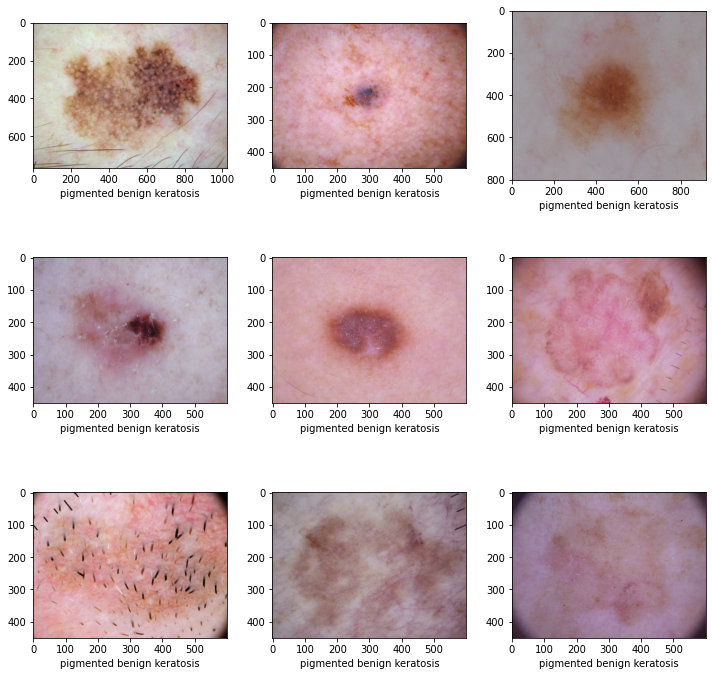

In [18]:
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    #print(arr.shape)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()
# image size and number of channels differ each other

## Prepare training, validation and test data lists

In [ ]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(t_image_file_list)
testY=np.array(t_image_label_list)

In [ ]:
trainX

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [ ]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [ ]:
class MyResize(Transform):
    def __init__(self, size=(150,200)):
        self.size = size
    def __call__(self, inputs):
        image2=cv2.resize(inputs,dsize=(self.size[1],self.size[0]),interpolation=cv2.INTER_CUBIC)
        return image2

In [ ]:
train_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

test_transforms = Compose([
    LoadImage(image_only=True),
    Resize((-1,1)),
    SumDimension(2),
    MyResize(),
    AddChannel(),    
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class, n_classes=num_class)

In [ ]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [ ]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(testX, testY, test_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

In [ ]:
device = torch.device("cuda:0")   #"cuda:0"
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 80
val_interval = 1

In [ ]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())     ##### 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images.float())], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


## Plot the loss and metric

In [ ]:
plt.figure('train', (12,6))
plt.subplot(1,2,1)
plt.title("Epoch Average Loss")
x = [i+1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1,2,2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i+1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x,y)
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        pred = model(val_images.float()).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(val_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [ ]:
t_y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images.float()).argmax(dim=1)
        for i in range(len(pred)):
            t_y_pred.append(pred[i].item())

In [ ]:
t_num_total=len(t_image_file_list)
plt.subplots(3,3, figsize=(10,10))
for i,k in enumerate(np.random.randint(t_num_total, size=9)):
    im = Image.open(t_image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[t_y_pred[i]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()